In [33]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [34]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62', 'PV_126']
block_lists = [[23,24,38],[7,8,9]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 038 at Path: Z:\Nimrod\experiments\PV_62\2023_05_01\block_038, new OE version
Found the sample rate for block 038 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 038
got it!
instantiated block number 007 at Path: Z:\Nimrod\experi

In [35]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 038 has a parsed events file, reading...
Getting eye brightness values for block 038...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [36]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=True,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


77it [00:00, 762.42it/s]

PV_62, block 023, on 2023-04-27_10-52-42


602it [00:00, 774.78it/s]
599it [00:00, 702.23it/s]
76it [00:00, 752.47it/s]

PV_62, block 024, on 2023-04-27_11-22-56


602it [00:00, 745.97it/s]
599it [00:00, 742.64it/s]
74it [00:00, 739.81it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1126it [00:01, 705.93it/s]
1123it [00:01, 707.59it/s]
77it [00:00, 762.42it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 728.86it/s]
1180it [00:01, 742.11it/s]
72it [00:00, 720.00it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


366it [00:00, 681.56it/s]
399it [00:00, 521.75it/s]
72it [00:00, 719.81it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


359it [00:00, 723.79it/s]
434it [00:00, 695.54it/s]


In [37]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\PV126_Trial16_wake3_2024-07-18_12-49-12\Record Node 102\analysis\recNames=block_007,Animal=PV_126\lizMov.mat
liz_mov_df created for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
path to mat file is Z:\Nimrod\experim

In [38]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [39]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [40]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


577it [00:00, 7490.99it/s]
577it [00:00, 7589.27it/s]
0it [00:00, ?it/s]

199 568
199 568


1034it [00:00, 6041.65it/s]
741it [00:00, 7407.89it/s]

599 1064


1163it [00:00, 7090.28it/s]
341it [00:00, 7417.54it/s]
338it [00:00, 7343.52it/s]


342 1110
181 386
204 414


In [41]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Reset to default settings
plt.rcdefaults()
import numpy as np
import pandas as pd
# make pdf compatible
from matplotlib import rc
rc('pdf', fonttype=42)
from matplotlib import rcParams
# Font settings for consistency
rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8
})
def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60, export_path=None):
    """
    This function compares monocular saccades against the opposite eye's movement.
    
    Parameters:
    - non_synced_saccade_collection: DataFrame with monocular saccades.
    - block_dict: Dictionary containing block instances.
    - window_ms: Temporal window around the saccade (default: 200ms).
    - sampling_rate: Data sampling rate in Hz (default: 60).
    
    Returns:
    - Displays average saccade profiles.
    """

    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(0,expected_length) * 1000/60) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue
        
        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data
        
        
        
        saccade_profile = current_eye_data.query('ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query('ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        if block_num == '007':
            print('hi')
        
        if len(saccade_profile) == expected_length and len(opposite_profile) == expected_length:
            saccade_profiles.append(saccade_profile)
            opposite_eye_profiles.append(opposite_profile)
        elif abs(len(saccade_profile) - expected_length) <= 10 and abs(len(opposite_profile) - expected_length) <= 10:
            saccade_profiles.append(np.pad(saccade_profile, (0, expected_length - len(saccade_profile)), constant_values=np.nan))
            opposite_eye_profiles.append(np.pad(opposite_profile, (0, expected_length - len(opposite_profile)), constant_values=np.nan))
        else:
            print(f"Skipped saccade at {start_ts} due to length mismatch.")

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = export_path / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = os.path.join(export_dir, "saccade_profiles.pkl")
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles

export_path =pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\material\Monocular_saccade_averages') 
saccade_profiles = average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=1000, sampling_rate=60, export_path=export_path)

Skipped saccade at 304658.9 due to length mismatch.
hi


ValueError: index can't contain negative values

In [11]:
# debugging here: 

In [20]:
window_ms = 200 
sampling_rate =60
half_window = window_ms // 2
expected_length = int(np.round((window_ms / 1000) * sampling_rate))
time_axis = (np.arange(0,expected_length) * 1000/60) - half_window

saccade_profiles = []
opposite_eye_profiles = []

for _, row in non_synced_saccade_collection.iterrows():
    block_num = row['block']
    eye = row['eye']
    start_ts = row['saccade_on_ms']
    opposite_eye = 'L' if eye == 'R' else 'R'

    block_key = f"{row['animal']}_block_{block_num}"
    if block_key not in block_dict:
        continue
    
    block = block_dict[block_key]
    current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
    opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data
    
    
    
    saccade_profile = current_eye_data.query('ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
    opposite_profile = opposite_eye_data.query('ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
    if block_num == '007':
        print('hi')
    
    if len(saccade_profile) == expected_length and len(opposite_profile) == expected_length:
        saccade_profiles.append(saccade_profile)
        opposite_eye_profiles.append(opposite_profile)
    elif abs(len(saccade_profile) - expected_length) <= 10 and abs(len(opposite_profile) - expected_length) <= 10:
        saccade_profiles.append(np.pad(saccade_profile, (0, expected_length - len(saccade_profile)), constant_values=np.nan))
        opposite_eye_profiles.append(np.pad(opposite_profile, (0, expected_length - len(opposite_profile)), constant_values=np.nan))
    else:
        print(f"Skipped saccade at {start_ts} due to length mismatch.")

if not saccade_profiles or not opposite_eye_profiles:
    print("No valid saccade profiles found.")


avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.tick_params(axis='both', which='major', length=5, color='black')
ax.ticklabel_format(axis='y', style='plain')
ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
ax.tick_params(axis='both', labelsize=8)
ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
ax.set_title("Average Saccade Profiles")
ax.set_xlabel("Time (ms)")
ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
plt.show()





hi


ValueError: index can't contain negative values

In [31]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def process_profile(profile, expected_length):
    """
    Adjusts a profile to the expected length by either padding or snipping.
    """
    current_length = len(profile)
    
    if current_length == expected_length:
        return profile

    # Snip or pad to match the expected length
    if current_length > expected_length:
        excess = (current_length - expected_length) // 2
        return profile[excess:excess + expected_length]
    else:
        pad_before = (expected_length - current_length) // 2
        pad_after = expected_length - current_length - pad_before
        return np.pad(profile, (pad_before, pad_after), constant_values=np.nan)

def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60, export_path=None):
    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(expected_length) * 1000 / sampling_rate) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue
        
        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data
        
        saccade_profile = current_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values

        if len(saccade_profile) == 0 or len(opposite_profile) == 0:
            print(f"Skipped saccade at {start_ts} due to missing data.")
            continue

        # Ensure fixed length through padding or snipping
        saccade_profiles.append(process_profile(saccade_profile, expected_length))
        opposite_eye_profiles.append(process_profile(opposite_profile, expected_length))

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    # Plot the results
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    # Save results
    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = export_dir / "saccade_profiles.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles, opposite_eye_profiles


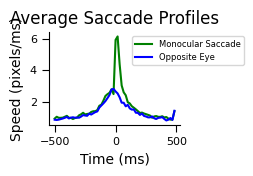

In [45]:
export_path =pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages') 
saccade_profiles = average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=1000, sampling_rate=60, export_path=None)

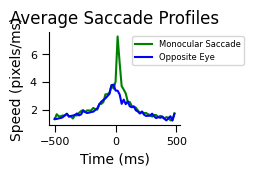

In [46]:
no_head_mov_saccades = non_synced_saccade_collection.query('head_movement == True')
export_path =pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages_no_head_mov') 
saccade_profiles = average_saccade_profile(no_head_mov_saccades, block_dict, window_ms=1000, sampling_rate=60, export_path=None)

In [43]:
non_synced_saccade_collection.query('head_movement == False')

0      False
1      False
9      False
11     False
13      True
       ...  
428    False
430    False
431    False
432    False
433    False
Name: head_movement, Length: 3231, dtype: bool